# Imports
Importing all necessary libraries and packages

In [1]:
import os
from tqdm import tqdm
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Device Setup
Setting device to `CUDA` to obtain faster and better results

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda


# Seed
Applying seed to `numpy` & `torch` to obtain consistent result on every execution

In [3]:
def setSeed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

setSeed()

# Transformation
Resizing the images to `128x128` pixels and converting them to `tensors`

In [4]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir = 'dataset'
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print(f'Classes: {dataset.classes}')
print(f'Total images: {len(dataset)}')

Classes: ['Bengin cases', 'Malignant cases', 'Normal cases']
Total images: 1097


# Class Distribution Plot
Plotting the distribution of each class in the dataset

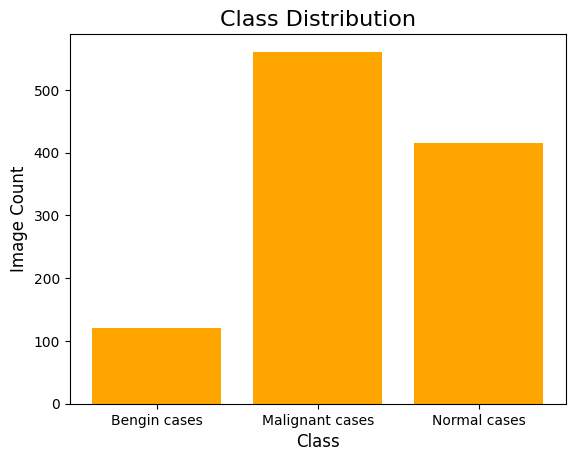

Bengin cases : 120
Malignant cases : 561
Normal cases : 416


In [5]:
class_counts = Counter([label for _, label in dataset.samples])
classes = list(dataset.classes)
counts = [class_counts[i] for i in range(len(classes))]

plt.bar(classes, counts, color='orange')

plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Image Count', fontsize=12)
plt.show()

for cls, cnt in zip(classes, counts):
    print(f"{cls:10s} : {cnt}")

# Dataset Split
Spliiting the dataset:
- 70% for **training**
- 15% for **validation**
- 15% for **testing**

In [7]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f'Train: {len(train_ds)}, Val: {len(val_ds)}, Test: {len(test_ds)}')

Train: 767, Val: 164, Test: 166


# Random Images Per Class
Showing 4 images from each class of the dataset

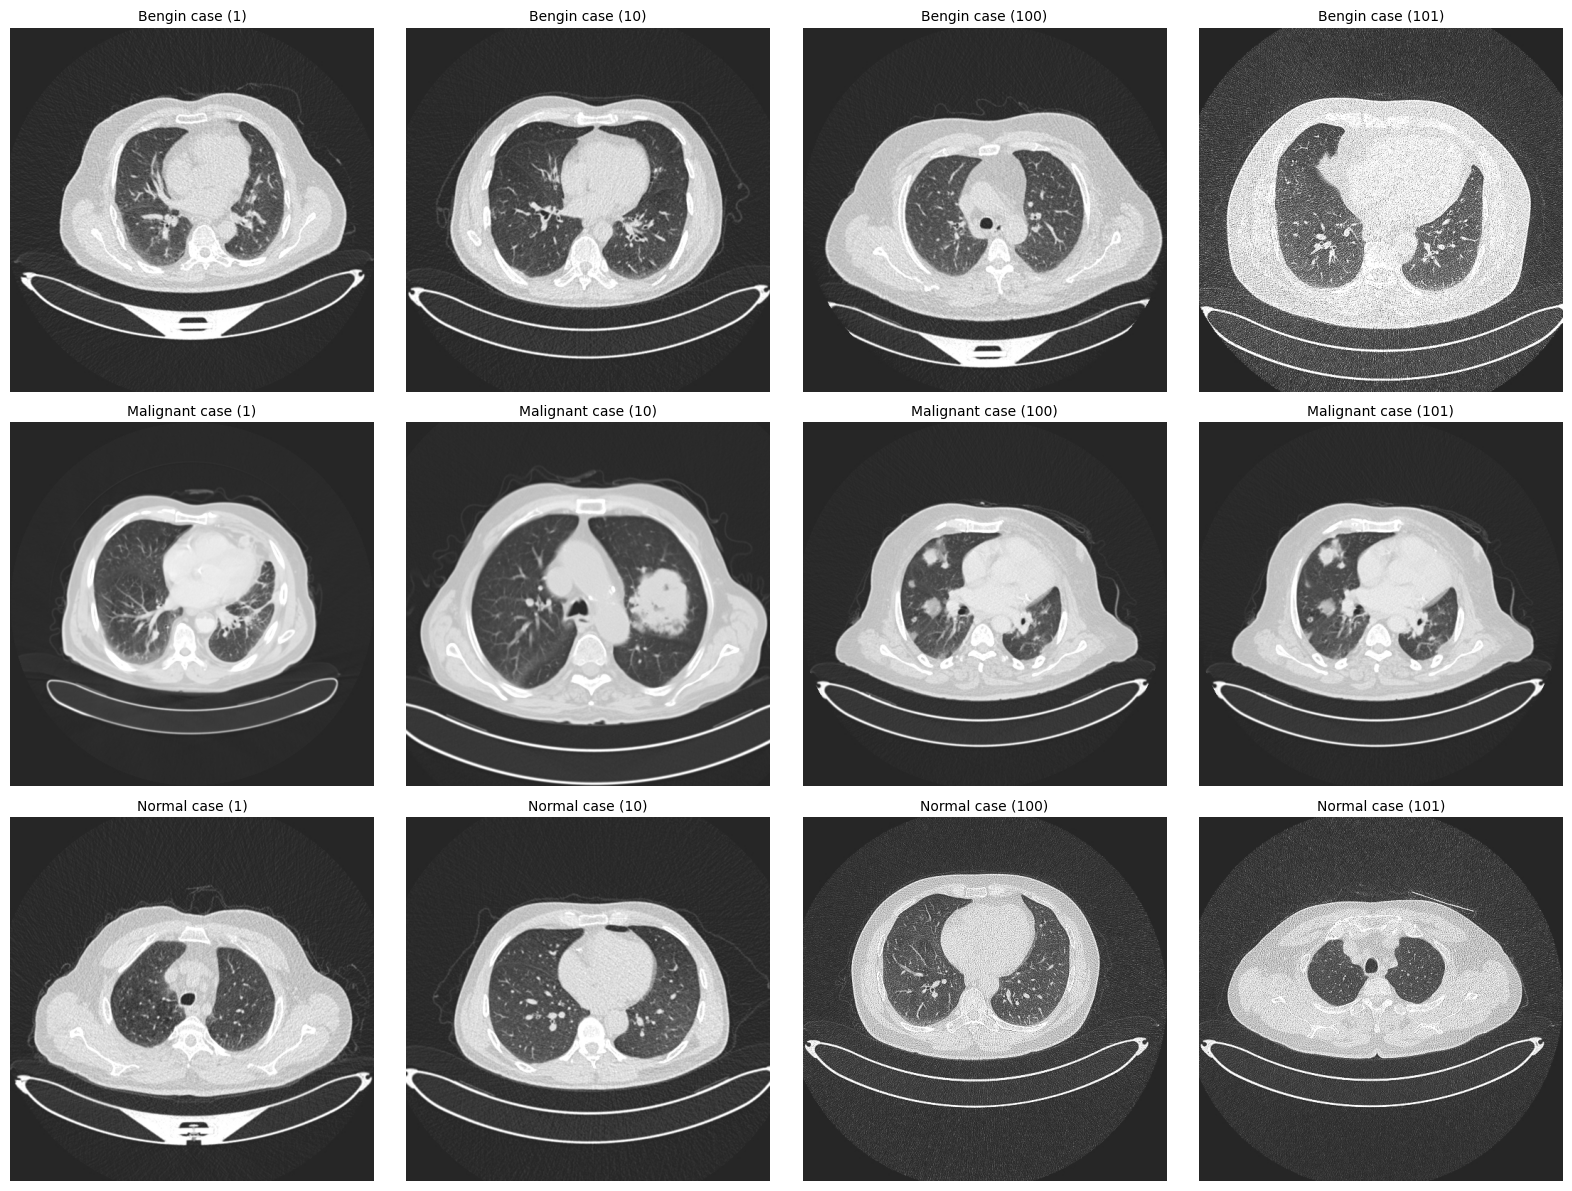

In [8]:
n_per_class = 4

samples = dataset.samples
classes = dataset.classes

fig, axes = plt.subplots(len(classes), n_per_class, figsize=(n_per_class * 4, len(classes) * 4))

for i, cls in enumerate(classes):
    cls_imgs = [path for path, label in samples if label == i][:n_per_class]
    
    for j, path in enumerate(cls_imgs):
        img = Image.open(path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')

        label = os.path.splitext(os.path.basename(path))[0]
        axes[i, j].set_title(label, fontsize=10, pad=5)
        
        if j == 0:
            axes[i, j].set_ylabel(cls, rotation=0, labelpad=30, fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

# CNN Model Architecture
Defining the actual CNN architecture which will predict the lung cancer images

In [9]:
class LungCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(LungCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d((6, 6))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 6 * 6, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = LungCNN(num_classes=3).to(device)
print(model)

LungCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=3, bias=True)
  )
)


# Loss & Optimer Setup
Setting loss and optimizer for the CNN

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
Here the model actually trains and learns the pattern to predict and classify the lung cancer types. It also saves the **best model weights** based on the minimum `validation loss` which it can achieve.

In [ ]:
num_epochs = 50
best_val_acc = 0.0
best_val_loss = np.inf
best_model_wts = copy.deepcopy(model.state_dict())

os.makedirs('checkpoints', exist_ok=True)
save_path = 'checkpoints/model.pth'

train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 40)
    
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc='Training', leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation', leave=True):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * correct_val / total_val

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_acc = val_acc
        best_val_loss = val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, save_path)
        print(f'Best model updated and saved (Val Loss: {val_loss:.2f})')

print("\nTraining complete")
print(f'Best Validation Accuracy (with minimal loss): {best_val_acc:.2f}%')

model.load_state_dict(best_model_wts)
print('Restored best model weights')


Epoch 1/50
----------------------------------------


Train Loss: 0.9581 | Train Acc: 51.37%
Val   Loss: 0.8553 | Val   Acc: 59.76%
Best model updated and saved (Val Loss: 0.86)

Epoch 2/50
----------------------------------------


Train Loss: 0.9010 | Train Acc: 56.32%
Val   Loss: 0.7786 | Val   Acc: 68.29%
Best model updated and saved (Val Loss: 0.78)

Epoch 3/50
----------------------------------------


Train Loss: 0.8543 | Train Acc: 59.97%
Val   Loss: 0.7259 | Val   Acc: 67.68%
Best model updated and saved (Val Loss: 0.73)

Epoch 4/50
----------------------------------------


Train Loss: 0.8282 | Train Acc: 60.10%
Val   Loss: 0.6886 | Val   Acc: 69.51%
Best model updated and saved (Val Loss: 0.69)

Epoch 5/50
----------------------------------------


Train Loss: 0.8202 | Train Acc: 63.10%
Val   Loss: 0.6961 | Val   Acc: 68.90%

Epoch 6/50
----------------------------------------


Train Loss: 0.7899 | Train Acc: 65.58%
Val   Loss: 0.6188 | Val   Acc: 78.05%
Best model updated and saved (Val Loss: 0.62)

Epoch 7/50
----------------------------------------


Train Loss: 0.7658 | Train Acc: 66.75%
Val   Loss: 0.6099 | Val   Acc: 77.44%
Best model updated and saved (Val Loss: 0.61)

Epoch 8/50
----------------------------------------


Train Loss: 0.7385 | Train Acc: 68.32%
Val   Loss: 0.6195 | Val   Acc: 71.95%

Epoch 9/50
----------------------------------------


Train Loss: 0.7132 | Train Acc: 68.19%
Val   Loss: 0.5331 | Val   Acc: 79.27%
Best model updated and saved (Val Loss: 0.53)

Epoch 10/50
----------------------------------------


Train Loss: 0.6902 | Train Acc: 72.49%
Val   Loss: 0.4952 | Val   Acc: 81.10%
Best model updated and saved (Val Loss: 0.50)

Epoch 11/50
----------------------------------------


Train Loss: 0.6416 | Train Acc: 73.92%
Val   Loss: 0.4826 | Val   Acc: 81.71%
Best model updated and saved (Val Loss: 0.48)

Epoch 12/50
----------------------------------------


Train Loss: 0.6542 | Train Acc: 71.19%
Val   Loss: 0.5650 | Val   Acc: 72.56%

Epoch 13/50
----------------------------------------


Train Loss: 0.6400 | Train Acc: 73.53%
Val   Loss: 0.4418 | Val   Acc: 80.49%
Best model updated and saved (Val Loss: 0.44)

Epoch 14/50
----------------------------------------


Train Loss: 0.5943 | Train Acc: 76.01%
Val   Loss: 0.4404 | Val   Acc: 83.54%
Best model updated and saved (Val Loss: 0.44)

Epoch 15/50
----------------------------------------


Train Loss: 0.5725 | Train Acc: 76.40%
Val   Loss: 0.4234 | Val   Acc: 84.15%
Best model updated and saved (Val Loss: 0.42)

Epoch 16/50
----------------------------------------


Train Loss: 0.5282 | Train Acc: 79.14%
Val   Loss: 0.4035 | Val   Acc: 84.15%
Best model updated and saved (Val Loss: 0.40)

Epoch 17/50
----------------------------------------


Train Loss: 0.5177 | Train Acc: 79.14%
Val   Loss: 0.3915 | Val   Acc: 85.98%
Best model updated and saved (Val Loss: 0.39)

Epoch 18/50
----------------------------------------


Train Loss: 0.4922 | Train Acc: 81.62%
Val   Loss: 0.3350 | Val   Acc: 86.59%
Best model updated and saved (Val Loss: 0.34)

Epoch 19/50
----------------------------------------


Train Loss: 0.4721 | Train Acc: 80.57%
Val   Loss: 0.3269 | Val   Acc: 85.98%
Best model updated and saved (Val Loss: 0.33)

Epoch 20/50
----------------------------------------


Train Loss: 0.4845 | Train Acc: 80.44%
Val   Loss: 0.3233 | Val   Acc: 86.59%
Best model updated and saved (Val Loss: 0.32)

Epoch 21/50
----------------------------------------


Train Loss: 0.4513 | Train Acc: 82.79%
Val   Loss: 0.3033 | Val   Acc: 88.41%
Best model updated and saved (Val Loss: 0.30)

Epoch 22/50
----------------------------------------


Train Loss: 0.4530 | Train Acc: 81.62%
Val   Loss: 0.3138 | Val   Acc: 87.20%

Epoch 23/50
----------------------------------------


Train Loss: 0.4375 | Train Acc: 83.18%
Val   Loss: 0.3005 | Val   Acc: 86.59%
Best model updated and saved (Val Loss: 0.30)

Epoch 24/50
----------------------------------------


Train Loss: 0.4386 | Train Acc: 82.66%
Val   Loss: 0.2857 | Val   Acc: 87.80%
Best model updated and saved (Val Loss: 0.29)

Epoch 25/50
----------------------------------------


Train Loss: 0.3956 | Train Acc: 83.96%
Val   Loss: 0.2987 | Val   Acc: 87.20%

Epoch 26/50
----------------------------------------


Train Loss: 0.3858 | Train Acc: 84.49%
Val   Loss: 0.2754 | Val   Acc: 87.20%
Best model updated and saved (Val Loss: 0.28)

Epoch 27/50
----------------------------------------


Train Loss: 0.3746 | Train Acc: 85.53%
Val   Loss: 0.2482 | Val   Acc: 88.41%
Best model updated and saved (Val Loss: 0.25)

Epoch 28/50
----------------------------------------


Train Loss: 0.3737 | Train Acc: 84.49%
Val   Loss: 0.2698 | Val   Acc: 88.41%

Epoch 29/50
----------------------------------------


Train Loss: 0.3585 | Train Acc: 85.66%
Val   Loss: 0.2349 | Val   Acc: 90.24%
Best model updated and saved (Val Loss: 0.23)

Epoch 30/50
----------------------------------------


Train Loss: 0.3205 | Train Acc: 87.22%
Val   Loss: 0.1941 | Val   Acc: 92.68%
Best model updated and saved (Val Loss: 0.19)

Epoch 31/50
----------------------------------------


Train Loss: 0.3051 | Train Acc: 88.14%
Val   Loss: 0.2057 | Val   Acc: 92.07%

Epoch 32/50
----------------------------------------


Train Loss: 0.2761 | Train Acc: 88.40%
Val   Loss: 0.1778 | Val   Acc: 91.46%
Best model updated and saved (Val Loss: 0.18)

Epoch 33/50
----------------------------------------


Train Loss: 0.3098 | Train Acc: 87.09%
Val   Loss: 0.2080 | Val   Acc: 91.46%

Epoch 34/50
----------------------------------------


Train Loss: 0.3147 | Train Acc: 87.74%
Val   Loss: 0.1937 | Val   Acc: 90.85%

Epoch 35/50
----------------------------------------


Train Loss: 0.2946 | Train Acc: 86.57%
Val   Loss: 0.2168 | Val   Acc: 89.63%

Epoch 36/50
----------------------------------------


Train Loss: 0.3111 | Train Acc: 87.09%
Val   Loss: 0.2198 | Val   Acc: 94.51%

Epoch 37/50
----------------------------------------


Train Loss: 0.2686 | Train Acc: 89.44%
Val   Loss: 0.1739 | Val   Acc: 90.24%
Best model updated and saved (Val Loss: 0.17)

Epoch 38/50
----------------------------------------


Train Loss: 0.2452 | Train Acc: 91.13%
Val   Loss: 0.1464 | Val   Acc: 92.68%
Best model updated and saved (Val Loss: 0.15)

Epoch 39/50
----------------------------------------


Train Loss: 0.2381 | Train Acc: 89.96%
Val   Loss: 0.1364 | Val   Acc: 95.73%
Best model updated and saved (Val Loss: 0.14)

Epoch 40/50
----------------------------------------


Train Loss: 0.2194 | Train Acc: 92.05%
Val   Loss: 0.1297 | Val   Acc: 93.29%
Best model updated and saved (Val Loss: 0.13)

Epoch 41/50
----------------------------------------


Train Loss: 0.2317 | Train Acc: 91.13%
Val   Loss: 0.1913 | Val   Acc: 92.07%

Epoch 42/50
----------------------------------------


Train Loss: 0.2485 | Train Acc: 90.35%
Val   Loss: 0.1304 | Val   Acc: 95.12%

Epoch 43/50
----------------------------------------


Train Loss: 0.2025 | Train Acc: 92.70%
Val   Loss: 0.1099 | Val   Acc: 96.34%
Best model updated and saved (Val Loss: 0.11)

Epoch 44/50
----------------------------------------


Train Loss: 0.1887 | Train Acc: 92.70%
Val   Loss: 0.1121 | Val   Acc: 96.95%

Epoch 45/50
----------------------------------------


Train Loss: 0.1981 | Train Acc: 92.05%
Val   Loss: 0.1035 | Val   Acc: 96.34%
Best model updated and saved (Val Loss: 0.10)

Epoch 46/50
----------------------------------------


Train Loss: 0.1760 | Train Acc: 92.70%
Val   Loss: 0.1098 | Val   Acc: 97.56%

Epoch 47/50
----------------------------------------


Train Loss: 0.1776 | Train Acc: 94.26%
Val   Loss: 0.1084 | Val   Acc: 96.34%

Epoch 48/50
----------------------------------------


Train Loss: 0.1922 | Train Acc: 92.70%
Val   Loss: 0.1029 | Val   Acc: 96.34%
Best model updated and saved (Val Loss: 0.10)

Epoch 49/50
----------------------------------------


Train Loss: 0.1751 | Train Acc: 94.13%
Val   Loss: 0.1018 | Val   Acc: 96.95%
Best model updated and saved (Val Loss: 0.10)

Epoch 50/50
----------------------------------------


Train Loss: 0.1698 | Train Acc: 94.39%
Val   Loss: 0.1132 | Val   Acc: 95.73%

Training complete
Best Validation Accuracy (with minimal loss): 96.95%
Restored best model weights


# Training Loss Plot
Plotting the training versus validation loss during training

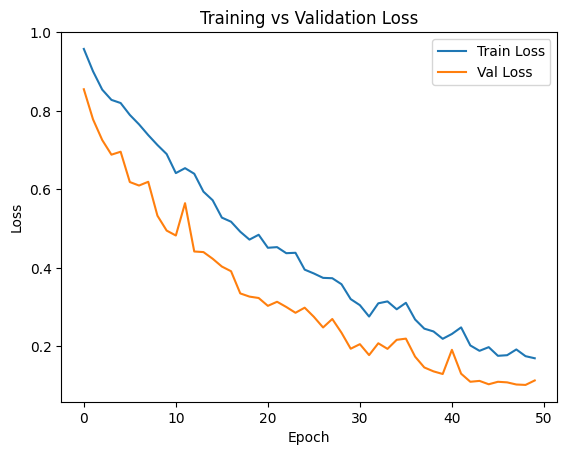

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Inference Results
Printing the classification report and plotting the confusion matrix based on the data of the test dataset

                 precision    recall  f1-score   support

   Bengin cases       0.88      0.71      0.79        21
Malignant cases       0.95      1.00      0.97        73
   Normal cases       0.94      0.94      0.94        72

       accuracy                           0.94       166
      macro avg       0.92      0.89      0.90       166
   weighted avg       0.94      0.94      0.94       166



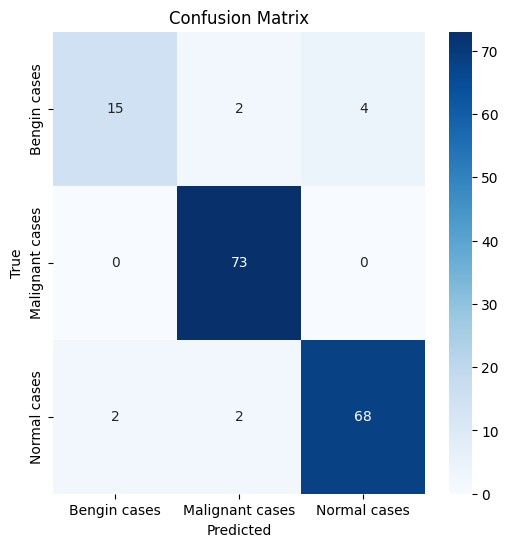

In [14]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=dataset.classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()